# Fighting Fire with Data - Starter Notebook

This notebook contains some of the models that I tried before ending up with SARIMAX as the best performing model.

These include RidgeCV, RandomForest regressor, XGBoost regressor, Facebook Prophet, VAR (Vector Autoregressive) models

## 1.0 Setup

I uploaded the three data files in a Google Drive subfolder named Competitions which is in a folder named Data_Sc_Software_Eng. I then installed and imported the necessary Python modules.

In [33]:
import pandas as pd
from sklearn.linear_model import RidgeCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np

from prophet import Prophet
from statsmodels.tsa.vector_ar.var_model import VAR

import warnings
warnings.filterwarnings('ignore')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [50]:
# Load data files into pandas dataframe
path = "/content/drive/MyDrive/Data_Sc_Software_Eng/Competitions/"
train = pd.read_csv(path + 'Train.csv')
test = pd.read_csv(path + 'Test.csv')
ss = pd.read_csv(path + 'SampleSubmission.csv')

In [51]:
# The variable definitions
var_defs = pd.read_csv(path + 'variable_definitions.csv')
var_defs

,Variable,Description
0,ID,The IDs take the form of [area ID]_yyyy-mm-dd....
1,area,Area ID
2,date,The date that the data is aggregated over
3,lat,Latitude of the center of the area
4,lon,Longitude of the center of the area
5,burn_area,Percentage of the area burnt
6,climate_aet,"Actual evapotranspiration, derived using a one..."
7,climate_def,"Climate water deficit, derived using a one-dim..."
8,climate_pdsi,Palmer Drought Severity Index
9,climate_pet,Reference evapotranspiration (ASCE Penman-Mont...


In [ ]:
# The test set - notice there is no 'burn_area' column.
test.head(1)

,ID,lat,lon,climate_aet,climate_def,climate_pdsi,climate_pet,climate_pr,climate_ro,climate_soil,...,landcover_0,landcover_1,landcover_2,landcover_3,landcover_4,landcover_5,landcover_6,landcover_7,landcover_8,precipitation
0,0_2014-01-01,-15.858835,29.237029,1146,74,-451,1220,120,6,212,...,0.0,0.000615,0.015418,0.0,0.416704,0.023724,0.530016,0.013524,0.0,0.404243


## 2.0 EDA + Feature Engineering

In [ ]:
# Look at distribution of each variable
train.describe()

,lat,lon,burn_area,climate_aet,climate_def,climate_pdsi,climate_pet,climate_pr,climate_ro,climate_soil,...,landcover_0,landcover_1,landcover_2,landcover_3,landcover_4,landcover_5,landcover_6,landcover_7,landcover_8,precipitation
count,83148.000000,83148.000000,83148.000000,83148.000000,83148.000000,83148.000000,83148.000000,83148.000000,83148.000000,83148.000000,...,83148.000000,83148.000000,83148.000000,8.314800e+04,83148.000000,83148.000000,83148.000000,83148.000000,83148.000000,83148.000000
mean,-19.014557,29.860856,0.007632,484.491124,828.892721,-30.806237,1313.382992,54.576322,6.215134,305.477919,...,0.006158,0.000017,0.008583,4.066313e-08,0.160628,0.037453,0.785382,0.000354,0.001424,0.078551
std,1.588444,1.751090,0.029226,470.467480,546.934469,235.802930,315.209838,71.997561,21.480399,400.956123,...,0.053111,0.000141,0.059046,3.535121e-06,0.192957,0.106050,0.233953,0.001773,0.014233,0.104464
min,-22.358835,25.487029,0.000000,0.000000,0.000000,-563.000000,587.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000019,0.000000,0.000000,0.000000
25%,-20.358835,28.487029,0.000000,50.000000,375.000000,-212.000000,1081.000000,1.000000,0.000000,70.000000,...,0.000000,0.000000,0.000000,0.000000e+00,0.014993,0.000000,0.655322,0.000000,0.000000,0.002017
50%,-18.858835,29.987029,0.000000,302.000000,858.000000,-108.000000,1290.000000,22.000000,1.000000,149.000000,...,0.000000,0.000000,0.000000,0.000000e+00,0.076706,0.000139,0.880600,0.000000,0.000000,0.028503
75%,-17.858835,31.237029,0.000000,931.000000,1211.000000,142.000000,1517.000000,87.000000,4.000000,329.000000,...,0.000000,0.000000,0.000000,0.000000e+00,0.246498,0.015166,0.971209,0.000000,0.000000,0.125500
max,-15.858835,32.987029,0.843886,1713.000000,2614.000000,851.000000,2620.000000,501.000000,342.000000,3319.000000,...,0.828131,0.004918,0.711603,3.073689e-04,0.981472,0.881323,1.000000,0.016708,0.301823,0.801328


In [ ]:
# Check columns with missing values
train.isna().sum()

,0
ID,0
lat,0
lon,0
burn_area,0
climate_aet,0
climate_def,0
climate_pdsi,0
climate_pet,0
climate_pr,0
climate_ro,0


In [ ]:
# Check for duplicates
train.duplicated().sum()

0

<Axes: >

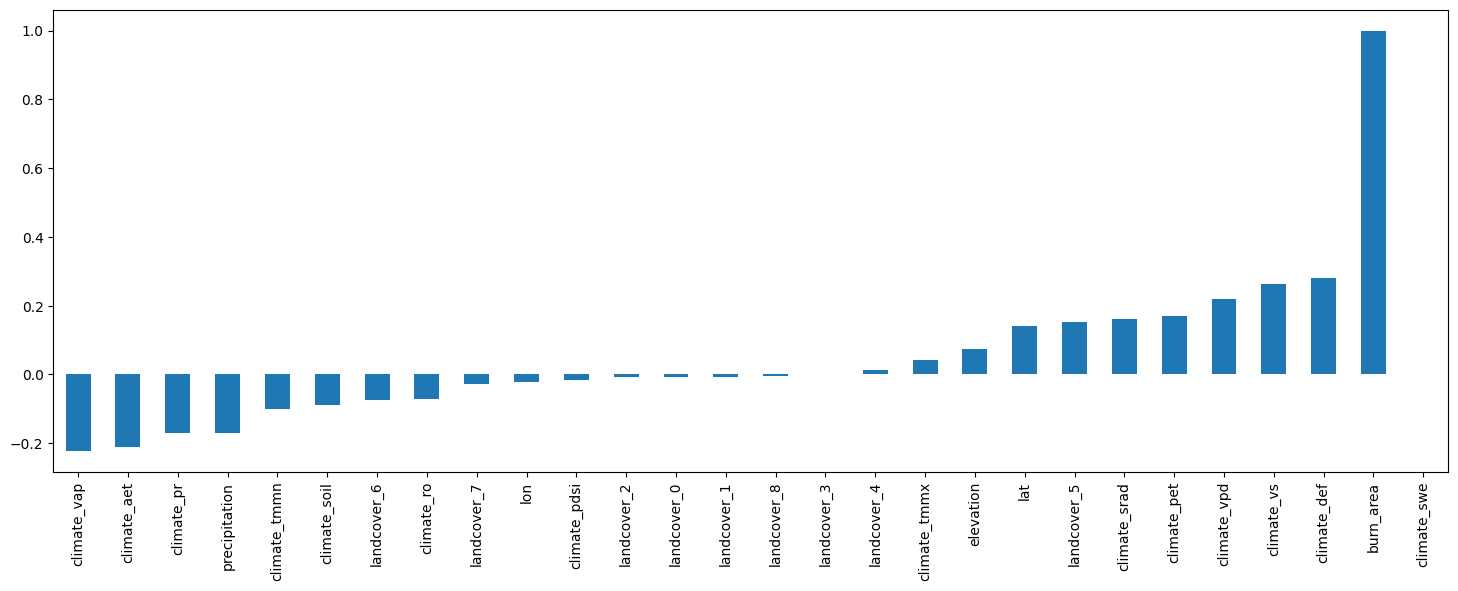

In [ ]:
# Look at correlation with target
train.select_dtypes(include=['number']).corr()['burn_area'].sort_values().plot(kind='bar', figsize=(18, 6))

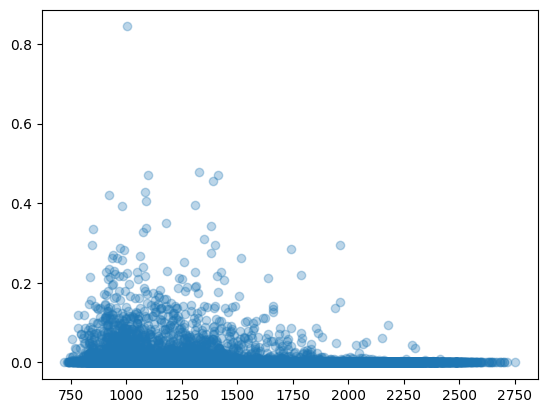

In [ ]:
# Look at some scatter plots (only plotting for a subset of data to keep things fast)
sample = train.sample(10000)
plt.scatter(sample['climate_vap'], sample['burn_area'], alpha=0.3)

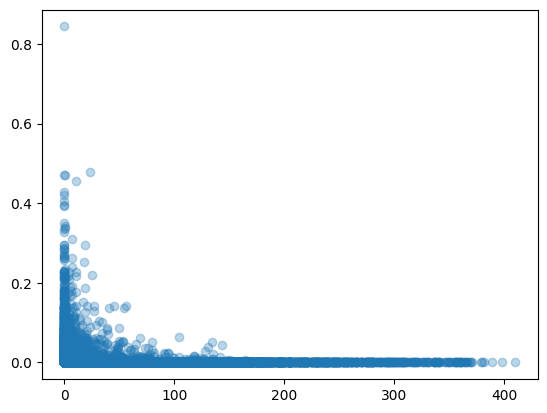

In [ ]:
# Most fires occur when there's very little rain.
plt.scatter(sample['climate_pr'], sample['burn_area'], alpha=0.3)

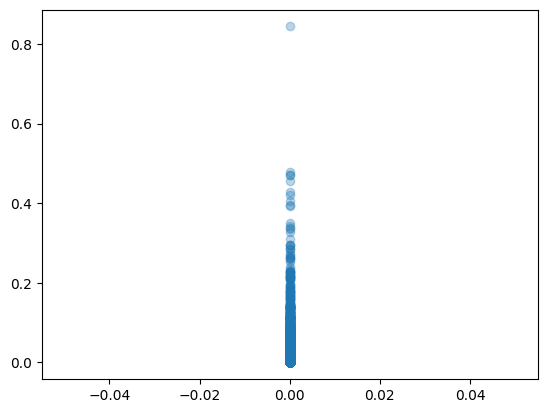

In [ ]:
# There is no snowing in Zimbabwe
plt.scatter(sample['climate_swe'], sample['burn_area'], alpha=0.3)

###  2.1 Adding date features

In [59]:
# Split the ID (eg 127_2017-01-03) to get the date string, which we convert to datetime to make life easier
train['date'] = pd.to_datetime(train['ID'].apply(lambda x: x.split('_')[1]))
test['date'] = pd.to_datetime(test['ID'].apply(lambda x: x.split('_')[1]))

In [60]:
# Date variables
train['month'] = train.date.dt.month
train['year'] = train.date.dt.year

In [61]:
# Group by month and calculate the mean burn_area
monthly_mean_burn_area = train.groupby('month')['burn_area'].mean().reset_index()

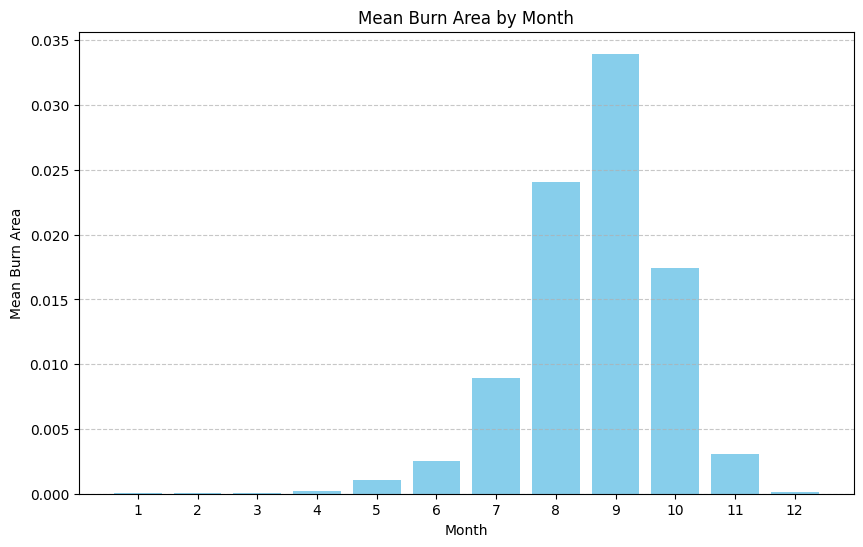

In [62]:
# Plot the results
plt.figure(figsize=(10, 6))
plt.bar(monthly_mean_burn_area['month'], monthly_mean_burn_area['burn_area'], color='skyblue')
plt.xlabel('Month')
plt.ylabel('Mean Burn Area')
plt.title('Mean Burn Area by Month')
plt.xticks(monthly_mean_burn_area['month'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [63]:
# Group by year and calculate the mean burn_area
yearly_mean_burn_area = train.groupby('year')['burn_area'].mean().reset_index()

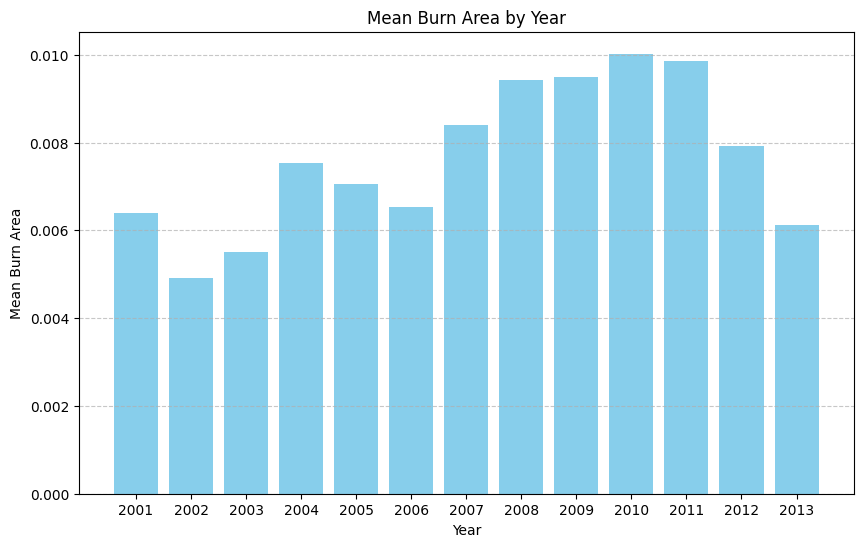

In [64]:
# Plot the results
plt.figure(figsize=(10, 6))
plt.bar(yearly_mean_burn_area['year'], yearly_mean_burn_area['burn_area'], color='skyblue')
plt.xlabel('Year')
plt.ylabel('Mean Burn Area')
plt.title('Mean Burn Area by Year')
plt.xticks(yearly_mean_burn_area['year'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

<Axes: xlabel='date'>

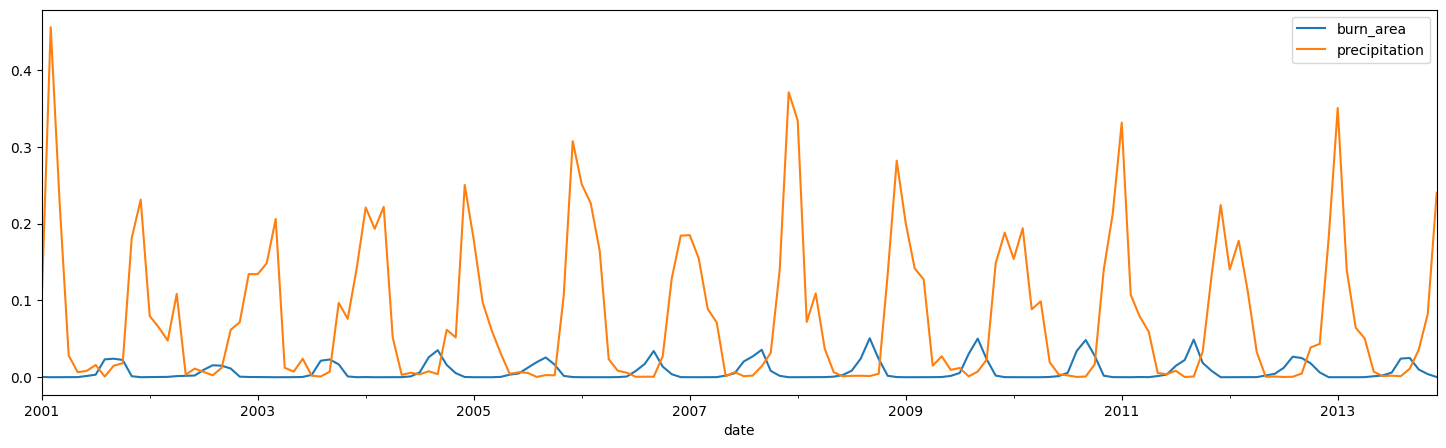

In [65]:
# Convert 'burn_area' to numeric, handling non-numeric values
train['burn_area'] = pd.to_numeric(train['burn_area'], errors='coerce')

# Now try plotting again
ax = train.groupby('date')['burn_area'].mean().reset_index().plot(y='burn_area', x='date', figsize=(18, 5))
train.groupby('date')['precipitation'].mean().reset_index().plot(y='precipitation', x='date', ax=ax)

### 2.2 Examining Collinearity

In [66]:
# Examining the correlation of all other columns with burned area
# Correlation coefficients for the various numeric variables

# Exclude the inappropriate columns from the ORIGINAL DataFrame
columns_to_exclude = ['ID', 'date', 'month', 'year']
numeric_columns = train.select_dtypes(include=['number']).drop(columns=columns_to_exclude, errors='ignore')
# The errors='ignore' will prevent an error if a column in columns_to_exclude is not present.

# Calculate the correlation with 'burn_area'
correlation_with_burn_area = numeric_columns.corr()['burn_area']

# Sort the correlation values
sorted_correlation_with_burn_area = correlation_with_burn_area.sort_values()

# Print the sorted correlation values
print(sorted_correlation_with_burn_area)

climate_vap     -0.221348
climate_aet     -0.211806
climate_pr      -0.170532
precipitation   -0.169218
climate_tmmn    -0.099436
climate_soil    -0.089246
landcover_6     -0.075815
climate_ro      -0.071414
landcover_7     -0.027734
lon             -0.021698
climate_pdsi    -0.014831
landcover_2     -0.008348
landcover_0     -0.008137
landcover_1     -0.007266
landcover_8     -0.005215
landcover_3      0.000964
landcover_4      0.013846
climate_tmmx     0.040500
elevation        0.074576
lat              0.140848
landcover_5      0.151957
climate_srad     0.160517
climate_pet      0.168871
climate_vpd      0.219974
climate_vs       0.261562
climate_def      0.279511
burn_area        1.000000
climate_swe           NaN
Name: burn_area, dtype: float64


In [67]:
# Examining Collinearity

# Exclude the non-numeric columns
columns_to_exclude = ['ID', 'date', 'month', 'year']
numeric_columns = train.drop(columns=columns_to_exclude).select_dtypes(include=['number'])

# Calculate the correlation matrix
correlation_matrix = numeric_columns.corr()

# Convert the correlation matrix to a long format
correlation_long = correlation_matrix.unstack().reset_index()
correlation_long.columns = ['feature1', 'feature2', 'correlation']

# Filter out self-correlations
correlation_long = correlation_long[correlation_long['feature1'] != correlation_long['feature2']]

# Sort by the absolute value of the correlation
sorted_correlations = correlation_long.reindex(correlation_long['correlation'].abs().sort_values(ascending=False).index)

# Reset the index for better readability
sorted_correlations.reset_index(drop=True, inplace=True)

# Print the sorted correlations
print(sorted_correlations)

          feature1       feature2  correlation
0    precipitation     climate_pr     0.914764
1       climate_pr  precipitation     0.914764
2     climate_tmmn    climate_vap     0.871724
3      climate_vap   climate_tmmn     0.871724
4      climate_aet     climate_pr     0.861178
..             ...            ...          ...
751    landcover_5    climate_swe          NaN
752    landcover_6    climate_swe          NaN
753    landcover_7    climate_swe          NaN
754    landcover_8    climate_swe          NaN
755  precipitation    climate_swe          NaN

[756 rows x 3 columns]


### 2.3 Data Split for Validation

We don't want to just split randomly - this would give us artificially high scores. Instead, let's use the last 3 years of the dataset for validation to more closely match the test configuration.

In [55]:
# Train test split
train_all = train.copy().dropna()
X_train = train_all.loc[train_all.date < '2011-01-01']
X_test = train_all.loc[train_all.date >= '2011-01-01']
print(X_train.shape, X_test.shape)

(63960, 32) (19188, 32)


In [56]:
# Define input and output columns - you can play with adding or removing inputs to the model
in_cols = ['climate_aet', 'climate_def',
       'climate_pdsi', 'climate_pet', 'climate_pr', 'climate_ro',
       'climate_soil', 'climate_srad', 'climate_swe', 'climate_tmmn',
       'climate_tmmx', 'climate_vap', 'climate_vpd', 'climate_vs', 'elevation',
       'landcover_0', 'landcover_1', 'landcover_2', 'landcover_3',
       'landcover_4', 'landcover_5', 'landcover_6', 'landcover_7',
       'landcover_8', 'precipitation']
target_col = 'burn_area'

In [29]:
# Get our X and y training and validation sets ready
X_train, y_train = X_train[in_cols], X_train[target_col]
X_test, y_test = X_test[in_cols], X_test[target_col]

##  3.0 Modelling

### 3.1 RidgeCV Models
#### 3.1.1 Simple Models

In [ ]:
# Create and fit the model
model = RidgeCV()
model.fit(X_train, y_train)

# Make predictions
preds = model.predict(X_test)

# Score
mean_squared_error(y_test, preds)**0.5 # RMSE - should match Zindi score. Lower is better

0.026804579066879393

In [ ]:
# RidgeCV with standardization
# Get our X and y training and validation sets ready
train_all = train.copy().dropna()
X_train = train_all.loc[train_all.date < '2011-01-01']
X_test = train_all.loc[train_all.date >= '2011-01-01']

X_train, y_train = X_train[in_cols], X_train[target_col]
X_test, y_test = X_test[in_cols], X_test[target_col]

# Standardization
scale = MinMaxScaler()
X_train_transformed = scale.fit_transform(X_train)
X_test_transformed = scale.transform(X_test)

# Create and fit the model
model = RidgeCV()
model.fit(X_train_transformed, y_train)

# Make predictions
preds = model.predict(X_test_transformed)

# Score
mean_squared_error(y_test, preds)**0.5 # RMSE - should match Zindi score. Lower is better

0.026804357891580918

#### 3.1.2 Dimensionality Reduction

In [ ]:
# Generate a dictionary of collinearity coefficients
# Initialize an empty dictionary to store the results
correlation_dict = {}

# Iterate over the sorted correlations DataFrame
for _, row in sorted_correlations.iterrows():
    # Create the key in the format 'feature1-with-feature2'
    key = f"{row['feature1']}-with-{row['feature2']}"

    # Assign the correlation value to the dictionary
    correlation_dict[key] = row['correlation']

# Print the dictionary
correlation_dict

{'precipitation-with-climate_pr': 0.9147643742708031,
 'climate_pr-with-precipitation': 0.9147643742708031,
 'climate_tmmn-with-climate_vap': 0.8717243802612049,
 'climate_vap-with-climate_tmmn': 0.8717243802612049,
 'climate_aet-with-climate_pr': 0.8611784406338812,
 'climate_pr-with-climate_aet': 0.8611784406338812,
 'climate_pet-with-climate_srad': 0.858159413884115,
 'climate_srad-with-climate_pet': 0.858159413884115,
 'landcover_4-with-landcover_6': -0.8228544263730088,
 'landcover_6-with-landcover_4': -0.8228544263730088,
 'climate_pet-with-climate_tmmx': 0.8203058342880352,
 'climate_tmmx-with-climate_pet': 0.8203058342880352,
 'climate_aet-with-climate_def': -0.8182961675708184,
 'climate_def-with-climate_aet': -0.8182961675708184,
 'climate_aet-with-precipitation': 0.8144643003395825,
 'precipitation-with-climate_aet': 0.8144643003395825,
 'climate_vpd-with-climate_pet': 0.7899400558654331,
 'climate_pet-with-climate_vpd': 0.7899400558654331,
 'climate_vap-with-climate_aet': 0

In [ ]:
# Generate unique feature pairs
# Initialize an empty dictionary to store the results
unique_correlations_dict = {}

# Iterate over the sorted correlations DataFrame
for _, row in sorted_correlations.iterrows():
    # Sort the feature names to handle swaps
    feature_pair = tuple(sorted([row['feature1'], row['feature2']]))

    # Create the key in the format 'feature1-with-feature2'
    key = f"{feature_pair[0]}-with-{feature_pair[1]}"

    # Assign the correlation value to the dictionary, ensuring no duplicates
    if key not in unique_correlations_dict:
        unique_correlations_dict[key] = row['correlation']

# # Print the dictionary
unique_correlations_dict

{'climate_pr-with-precipitation': 0.9147643742708031,
 'climate_tmmn-with-climate_vap': 0.8717243802612049,
 'climate_aet-with-climate_pr': 0.8611784406338812,
 'climate_pet-with-climate_srad': 0.858159413884115,
 'landcover_4-with-landcover_6': -0.8228544263730088,
 'climate_pet-with-climate_tmmx': 0.8203058342880352,
 'climate_aet-with-climate_def': -0.8182961675708184,
 'climate_aet-with-precipitation': 0.8144643003395825,
 'climate_pet-with-climate_vpd': 0.7899400558654331,
 'climate_aet-with-climate_vap': 0.7814346288371498,
 'climate_tmmn-with-climate_tmmx': 0.7658216146831184,
 'climate_tmmx-with-climate_vpd': 0.7506106443454477,
 'climate_def-with-climate_vpd': 0.7408227376999281,
 'climate_def-with-climate_pr': -0.7338949941290972,
 'climate_def-with-precipitation': -0.6993644274077669,
 'climate_pr-with-climate_ro': 0.6729281069103111,
 'climate_pr-with-climate_vap': 0.6651499234207582,
 'climate_aet-with-climate_tmmn': 0.6565213626367231,
 'climate_vap-with-precipitation': 0

In [30]:
# Select features to minimize multicollinearity
selected_features = [
    'climate_pr', 'climate_tmmn', 'climate_aet', 'climate_pet', 'landcover_4',
    'climate_tmmx', 'climate_def', 'precipitation', 'climate_vpd', 'landcover_1',
    'landcover_2', 'landcover_0', 'landcover_3', 'climate_soil',
    'elevation', 'climate_srad'
]
target_col = 'burn_area'

In [ ]:
len(selected_features)

16

#### 3.1.3 RidgeCV Models with minimized multicollinearity

In [ ]:
# Minimized multicollinearity without standardization
# Get our X and y training and validation sets ready
train_all = train.copy().dropna()
X_train = train_all.loc[train_all.date < '2011-01-01']
X_test = train_all.loc[train_all.date >= '2011-01-01']

X_train, y_train = X_train[selected_features], X_train[target_col]
X_test, y_test = X_test[selected_features], X_test[target_col]

# Create and fit the model
model = RidgeCV()
model.fit(X_train, y_train)

# Make predictions
preds = model.predict(X_test)

# Score
mean_squared_error(y_test, preds)**0.5 # RMSE - should match Zindi score. Lower is better

0.027366536987648862

In [ ]:
# Minimized multicollinearity with standardization
# Get our X and y training and validation sets ready
train_all = train.copy().dropna()
X_train = train_all.loc[train_all.date < '2011-01-01']
X_test = train_all.loc[train_all.date >= '2011-01-01']

X_train, y_train = X_train[selected_features], X_train[target_col]
X_test, y_test = X_test[selected_features], X_test[target_col]

# Standardization
scale = MinMaxScaler()
X_train_transformed = scale.fit_transform(X_train)
X_test_transformed = scale.transform(X_test)

# Create and fit the model
model = RidgeCV()
model.fit(X_train_transformed, y_train)

# Make predictions
preds = model.predict(X_test_transformed)

# Score
mean_squared_error(y_test, preds)**0.5 # RMSE - should match Zindi score. Lower is better

0.02736881921974534

### 3.2 RandomForest Regressor Models
#### 3.2.1 Simple Models


In [ ]:
# Full feature set with standardization
# Get our X and y training and validation sets ready
train_all = train.copy().dropna()
X_train = train_all.loc[train_all.date < '2011-01-01']
X_test = train_all.loc[train_all.date >= '2011-01-01']

X_train, y_train = X_train[in_cols], X_train[target_col]
X_test, y_test = X_test[in_cols], X_test[target_col]

# Standardization
scale = MinMaxScaler()
X_train_transformed = scale.fit_transform(X_train)
X_test_transformed = scale.transform(X_test)

# Initialize and train the RandomForest Regressor
rf_regressor = RandomForestRegressor(random_state=42)
rf_regressor.fit(X_train_transformed, y_train)

# Make predictions on the test set
y_pred = rf_regressor.predict(X_test_transformed)

# Score
mean_squared_error(y_test, y_pred)**0.5 # RMSE - should match Zindi score. Lower is better

0.02460326385977482

In [ ]:
# Full feature set without standardization
# Get our X and y training and validation sets ready
train_all = train.copy().dropna()
X_train = train_all.loc[train_all.date < '2011-01-01']
X_test = train_all.loc[train_all.date >= '2011-01-01']

X_train, y_train = X_train[in_cols], X_train[target_col]
X_test, y_test = X_test[in_cols], X_test[target_col]

# Initialize and train the RandomForest Regressor
rf_regressor = RandomForestRegressor(random_state=42)
rf_regressor.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_regressor.predict(X_test)

# Score
mean_squared_error(y_test, y_pred)**0.5 # RMSE - should match Zindi score. Lower is better

0.024590190850114813

In [ ]:
# Minimized multicollinearity with standardization
# Get our X and y training and validation sets ready
train_all = train.copy().dropna()
X_train = train_all.loc[train_all.date < '2011-01-01']
X_test = train_all.loc[train_all.date >= '2011-01-01']

X_train, y_train = X_train[selected_features], X_train[target_col]
X_test, y_test = X_test[selected_features], X_test[target_col]

# Standardization
scale = MinMaxScaler()
X_train_transformed = scale.fit_transform(X_train)
X_test_transformed = scale.transform(X_test)

# Initialize and train the RandomForest Regressor
rf_regressor = RandomForestRegressor(random_state=42)
rf_regressor.fit(X_train_transformed, y_train)

# Make predictions on the test set
y_pred = rf_regressor.predict(X_test_transformed)

# Score
mean_squared_error(y_test, y_pred)**0.5 # RMSE - should match Zindi score. Lower is better

0.025438225247214185

#### 3.2.2 RandomForest Regressor with hyperparameter tuning

In [ ]:
# Hyperparameter tuning - >=100 estimators
# Hyperparameter grid
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Initialize RandomForest Regressor
rf_regressor = RandomForestRegressor(random_state=42)

# Perform Randomized Search
rf_random = RandomizedSearchCV(estimator=rf_regressor, param_distributions=param_grid,
                               n_iter=100, cv=3, verbose=2, random_state=42, n_jobs=-1)

# Fit the random search model
rf_random.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_random.predict(X_test)

# Calculate the mean squared error
mse = mean_squared_error(y_test, y_pred)**0.5  # RMSE
print(f'Root Mean Squared Error: {mse}')

# Get the best parameters
print(f'Best parameters found: {rf_random.best_params_}')

Fitting 3 folds for each of 100 candidates, totalling 300 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
126 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
23 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", 

Root Mean Squared Error: 0.02285804382129087
Best parameters found: {'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'log2', 'max_depth': 40, 'bootstrap': False}


In [ ]:
# Evaluate model with cross-validation
scores = cross_val_score(rf_random.best_estimator_, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
rmse_scores = (-scores)**0.5
print(f'Cross-validated RMSE scores: {rmse_scores}')
print(f'Mean Cross-validated RMSE: {rmse_scores.mean()}')

Cross-validated RMSE scores: [0.02340136 0.02388104 0.02101403 0.02549896 0.02822972]
Mean Cross-validated RMSE: 0.024405022589795284


In [ ]:
# Retraining the randomforest regressor model on the whole dataset
# Create a new dataframe with only the columns in in_cols
train_in_cols = train[in_cols]

# Instantiate and fit the model on the entire dataset
# Define the best fr_random model parameters
best_params = rf_random.best_params_

# Create a new RandomForestRegressor model with the best parameters
rf_best = RandomForestRegressor(
    n_estimators=best_params['n_estimators'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    max_features=best_params['max_features'],
    max_depth=best_params['max_depth'],
    bootstrap=best_params['bootstrap'],
    random_state=42  # Keep the same random state for reproducibility
)

# Fit the model on the entire dataset
rf_best.fit(train_in_cols, train[target_col])

# Output to check if the model is fitted
print("Model trained on the entire dataset with best parameters.")

Model trained on the entire dataset with best parameters.


In [ ]:
# Hyperparameter tuning - >=10 estimators

# Get our X and y training and validation sets ready
train_all = train.copy().dropna()
X_train = train_all.loc[train_all.date < '2011-01-01']
X_test = train_all.loc[train_all.date >= '2011-01-01']

X_train, y_train = X_train[in_cols], X_train[target_col]
X_test, y_test = X_test[in_cols], X_test[target_col]

# Hyperparameter grid
param_grid = {
    'n_estimators': [10, 20, 30, 40, 50],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Initialize RandomForest Regressor
rf_regressor = RandomForestRegressor(random_state=42)

# Perform Randomized Search
rf_random = RandomizedSearchCV(estimator=rf_regressor, param_distributions=param_grid,
                               n_iter=100, cv=3, verbose=2, random_state=42, n_jobs=-1)

# Fit the random search model
rf_random.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_random.predict(X_test)

# Calculate the mean squared error
mse = mean_squared_error(y_test, y_pred)**0.5  # RMSE
print(f'Root Mean Squared Error: {mse}')

# Get the best parameters
print(f'Best parameters found: {rf_random.best_params_}')

### 3.3 Principal Component Reduction (PCA)

In [ ]:
# Split the data into X and y
X = X_train[in_cols]
y = X_train[target_col]

# Split X_test into X_test and y_test
X_test, y_test = X_test[in_cols], X_test[target_col]

# Mean
X_mean = X.mean()

# Standard deviation
X_std = X.std()

# Standardization
Z = (X - X_mean) / X_std

# Compute covariance matrix
cov_matrix = Z.cov()

# Drop rows and columns with NaNs in the covariance matrix
cov_matrix = cov_matrix.dropna(axis=0, how='all').dropna(axis=1, how='all')

# Compute eigenvectors and eigenvalues
eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)

# Sort the eigenvalues and the corresponding eigenvectors in descending order
# Index the eigenvalues in descending order
idx = eigenvalues.argsort()[::-1]
# Sort the eigenvalues in descending order
eigenvalues = eigenvalues[idx]
# sort the corresponding eigenvectors accordingly
eigenvectors = eigenvectors[:, idx]

# Compute explained variance of the eigenvalues
explained_var = np.cumsum(eigenvalues) / np.sum(eigenvalues)

# Determine the number of principal components
# with an explained variance of atleast 80%
n_components = np.argmax(explained_var >= 0.80) + 1

# print number of principal components
print("Number of Principal Components =", n_components)

# Create a dataframe of the principal components
# Instantiate PCA
pca = PCA(n_components=n_components)

# Fit PCA on X
X_train_pca = pca.fit_transform(X)

# PCA transform X_test
X_test_pca = pca.transform(X_test)

# Best parameters found from RandomizedSearchCV
best_params = {
    'n_estimators': 300,
    'min_samples_split': 5,
    'min_samples_leaf': 4,
    'max_features': 'log2',
    'max_depth': 40,
    'bootstrap': False
}

# Instiate a new RandomForestRegressor model with the best parameters
rf_best = RandomForestRegressor(
    n_estimators=best_params['n_estimators'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    max_features=best_params['max_features'],
    max_depth=best_params['max_depth'],
    bootstrap=best_params['bootstrap'],
    random_state=42  # Keep the same random state for reproducibility
)

# Fit the model on PCA transformed X_train
rf_best.fit(X_train_pca, y)

# Make predictions on the PCA transformed test set
y_pred = rf_best.predict(X_test_pca)

# Calculate the mean squared error
mse = mean_squared_error(y_test, y_pred)**0.5  # RMSE
print(f'Root Mean Squared Error: {mse}')

Number of Principal Components = 8
Root Mean Squared Error: 0.024915630133727183


In [58]:
# PCA transformation and hyperparameter tuning with >=100 estimators
# Hyperparameter grid
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Initialize RandomForest Regressor
rf_regressor_pca = RandomForestRegressor(random_state=42)

# Perform Randomized Search
rf_random_pca = RandomizedSearchCV(estimator=rf_regressor_pca, param_distributions=param_grid,
                               n_iter=100, cv=3, verbose=2, random_state=42, n_jobs=-1)

# Fit the random search model
rf_random_pca.fit(X_train_pca, y)

# Make predictions on the test set
y_pred = rf_random_pca.predict(X_test_pca)

# Calculate the mean squared error
mse = mean_squared_error(y_test, y_pred)**0.5  # RMSE
print(f'Root Mean Squared Error: {mse}')

# Get the best parameters
print(f'Best parameters found: {rf_random_pca.best_params_}')

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Root Mean Squared Error: 0.02468587614218849
Best parameters found: {'n_estimators': 500, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 50, 'bootstrap': True}


In [ ]:
# Evaluate model with cross-validation
scores = cross_val_score(rf_random_pca.best_estimator_, X_train_pca, y, cv=5, scoring='neg_mean_squared_error')
rmse_scores = (-scores)**0.5
print(f'Cross-validated RMSE scores: {rmse_scores}')
print(f'Mean Cross-validated RMSE: {rmse_scores.mean()}')

Cross-validated RMSE scores: [0.02469854 0.02490006 0.02322831 0.02761308 0.029492  ]
Mean Cross-validated RMSE: 0.025986400316054137


In [ ]:
# Retraining the PCA randomizedsearchCV model on the whole dataset
# Create a new dataframe with only the columns in in_cols
train_in_cols = train[in_cols]

# Fit PCA on train set
train_pca = pca.fit_transform(train_in_cols)

# Instantiate and fit the model on the entire dataset
# Define the best fr_random model parameters
best_params = rf_random_pca.best_params_

# Create a new RandomForestRegressor model with the best parameters
rf_best_pca = RandomForestRegressor(
    n_estimators=best_params['n_estimators'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    max_features=best_params['max_features'],
    max_depth=best_params['max_depth'],
    bootstrap=best_params['bootstrap'],
    random_state=42  # Keep the same random state for reproducibility
)

# Fit the model on the entire dataset
rf_best_pca.fit(train_pca, train[target_col])

# Output to check if the model is fitted
print("Model trained on the entire dataset with best parameters.")

Model trained on the entire dataset with best parameters.


### 3.4 XGBoost Model

Here we will train XGBoost on all numerical features including longitude and latitude.

In [38]:
# Select all numerical columns
selected_features = ['lat', 'lon', 'climate_aet', 'climate_def',
       'climate_pdsi', 'climate_pet', 'climate_pr', 'climate_ro',
       'climate_soil', 'climate_srad', 'climate_swe', 'climate_tmmn',
       'climate_tmmx', 'climate_vap', 'climate_vpd', 'climate_vs', 'elevation',
       'landcover_0', 'landcover_1', 'landcover_2', 'landcover_3',
       'landcover_4', 'landcover_5', 'landcover_6', 'landcover_7',
       'landcover_8', 'precipitation']
target_col = 'burn_area'

In [48]:
# Hyperparameter tuning of XGBoost with all numerical features
# Get our X and y training and validation sets ready
X_train, y_train = X_train[selected_features], X_train[target_col]
X_test, y_test = X_test[selected_features], X_test[target_col]

# Hyperparameter grid
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7, 10, 15],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.3, 0.5],
    'reg_alpha': [0, 0.01, 0.1, 1.0],
    'reg_lambda': [1.0, 0.1, 0.01]
}

# Initialize XGBoost Regressor
xgb_regressor = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# Perform Randomized Search
xgb_random = RandomizedSearchCV(estimator=xgb_regressor, param_distributions=param_grid,
                               n_iter=100, cv=3, verbose=2, random_state=42, n_jobs=-1)

# Fit the random search model
xgb_random.fit(X_train, y_train)

# Make predictions on the test set
y_pred = xgb_random.predict(X_test)

# Calculate the mean squared error
mse = mean_squared_error(y_test, y_pred)**0.5  # RMSE
print(f'Root Mean Squared Error: {mse}')

# Get the best parameters
print(f'Best parameters found: {xgb_random.best_params_}')

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Root Mean Squared Error: 0.0223199139035291
Best parameters found: {'subsample': 1.0, 'reg_lambda': 1.0, 'reg_alpha': 1.0, 'n_estimators': 200, 'max_depth': 15, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.6}


### 3.5 Facebook Prophet Model

Prophet is a procedure for forecasting univariate time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. It works best with time series that have strong seasonal effects and outliers.

In [31]:
# Split the ID (eg 127_2017-01-03) to get the area ID
train['real_id'] = pd.to_numeric(train['ID'].apply(lambda x: x.split('_')[0]))
test['real_id'] = pd.to_numeric(test['ID'].apply(lambda x: x.split('_')[0]))

In [32]:
# Train the Facebook Prophet model on the whole X_train data and predict on the X_test set

# Initialize an empty list to store RMSE for each area
rmse_values = []

# Loop through each area ID
for real_id in train['real_id'].unique():
    # Filter the train and test data for the current area ID
    train_area = train.loc[train.real_id == real_id]
    test_area = test.loc[test.real_id == real_id]

    # Set the date column as the index and convert to time series
    train_area.set_index('date', inplace=True)
    test_area.set_index('date', inplace=True)

    # Train Test Split
    X_train_area = train_area.loc[train_area.index.strftime('%Y-%m-%d') < '2011-01-01']
    y_test_area = train_area.loc[train_area.index.strftime('%Y-%m-%d') >= '2011-01-01']

    # Find the last date in the training data
    last_date = X_train_area.index[-1]

    # Increment the last date by one month to get the start date for forecasting
    start_date = last_date + pd.DateOffset(months=1)

    # Create a DataFrame with future dates starting from the next month with monthly frequency
    future = pd.DataFrame({'ds': pd.date_range(start=start_date, periods=len(y_test_area), freq='MS')}) # 36 months

    # Prepare the data for Prophet, ensuring it is in monthly frequency
    prophet_data = X_train_area.reset_index().rename(columns={'date': 'ds', 'burn_area': 'y'})

    # Ensure the 'ds' column in prophet_data is monthly
    prophet_data['ds'] = pd.to_datetime(prophet_data['ds']).dt.to_period('M').dt.to_timestamp()

    # Create and fit the Prophet model
    fb_model = Prophet()
    fb_model.fit(prophet_data)

    # Generate forecasts
    future_forecast = fb_model.predict(future)

    # Evaluate forecasts
    # Change the index of forecasted series
    future_forecast = future_forecast.set_index('ds')

    # Calculate rmse and append list
    rmse_area = np.sqrt(mean_squared_error(y_test_area['burn_area'], future_forecast['yhat']))
    rmse_values.append(rmse_area)

# Calculate the overall RMSE by averaging the RMSE values of all areas
if rmse_values:
    overall_rmse = np.mean(rmse_values)
    print('Overall Test RMSE:', overall_rmse)
else:
    print('No valid RMSE values were calculated')

Streaming output truncated to the last 5000 lines.
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=6055', 'data', 'file=/tmp/tmpktqh_yuw/yaln8d80.json', 'init=/tmp/tmpktqh_yuw/ryngi1x1.json', 'output', 'file=/tmp/tmpktqh_yuw/prophet_model8u_6_jbs/prophet_model-20240816113027.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:30:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:30:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpktqh_yuw/azmxs13k.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpktqh_yuw/i26g

Overall Test RMSE: 0.014736724817954457


### 3.6 VAR (Vector Autoregressive) Model

The high collinearity of some features shows high interdependence between them which means that the future values of each variable are partially influenced by those of another.

The VAR model enables multivariate modelling, but to minimize the computation time and errors, we will select a list of the most influential preidictor features.

In [34]:
min_features = ['climate_vap', 'climate_aet', 'climate_pr', 'precipitation', 'climate_pet', 'climate_tmmn', 'climate_soil',
                'landcover_5','climate_vpd', 'climate_vs', 'climate_def', 'climate_srad', 'burn_area']

In [35]:
# VAR model for all areas in a loop
# Initialize an empty list to store RMSE for each area
rmse_values = []

# Convert train and test to time series
train = train.set_index('date')
test = test.set_index('date')

# Loop through each area ID
for real_id in train['real_id'].unique():
    print(f"Processing area ID: {real_id}")

    # Time Series for area ID
    train_area = train.loc[train.real_id == real_id]
    test_area = test.loc[test.real_id == real_id]

    # Split the data into training and testing sets based on the date
    # Convert date to string and split at 2011-01-01
    X_train_area = train_area.loc[train_area.index.strftime('%Y-%m-%d') < '2011-01-01']
    y_test_area = train_area.loc[train_area.index.strftime('%Y-%m-%d') >= '2011-01-01']

    # Select the feature and target columns
    X_train_area = X_train_area[min_features]
    X_test_area = y_test_area[min_features]

    # Check multicollinearity in the training data
    corr_matrix = X_train_area.corr()
    if corr_matrix.isnull().values.any():
        print(f"Area {real_id} has NaNs in correlation matrix. Skipping...")
        continue

    # Drop highly correlated features if necessary
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column].abs() > 0.95)]
    if to_drop:
        print(f"Dropping columns for area {real_id} due to high correlation: {to_drop}")
        X_train_area = X_train_area.drop(columns=to_drop)
        X_test_area = X_test_area.drop(columns=to_drop)

    try:
        # Fit the VAR model
        var_model = VAR(X_train_area)

        # Select lag order using an information criterion (e.g., AIC)
        results = var_model.fit(ic='aic')

        # Forecasting for a period equal to the length of X_test
        forecast_horizon = len(X_test_area)

        # Generate the forecast
        forecast = results.forecast(X_train_area.values[-results.k_ar:], steps=forecast_horizon)

        # Generate the forecast index with monthly frequency
        forecast_index = pd.date_range(start=X_train_area.index[-1] + pd.DateOffset(months=1),
                                       periods=forecast_horizon, freq='MS')

        # Create a DataFrame for the forecast
        forecast_var = pd.DataFrame(forecast, index=forecast_index, columns=X_train_area.columns)

        # Align the forecast with the test data to ensure the indexes match
        forecast_var = forecast_var.reindex(X_test_area.index)

        # Evaluate the forecast with RMSE
        rmse_var = mean_squared_error(X_test_area['burn_area'], forecast_var['burn_area'], squared=False)
        rmse_values.append(rmse_var)
        print(f"RMSE for area {real_id}: {rmse_var}")

    except np.linalg.LinAlgError as e:
        print(f"Linear Algebra error for area {real_id}: {e}. Skipping...")
        continue
    except Exception as e:
        print(f"An error occurred for area {real_id}: {e}. Skipping...")
        continue

# Calculate the overall RMSE by averaging the RMSE values of all areas
if rmse_values:
    overall_rmse = np.mean(rmse_values)
    print('Overall Test RMSE:', overall_rmse)
else:
    print('No valid RMSE values were calculated')

Processing area ID: 0
RMSE for area 0: 0.008730052393475886
Processing area ID: 1
RMSE for area 1: 0.00012546928848621
Processing area ID: 2
Area 2 has NaNs in correlation matrix. Skipping...
Processing area ID: 3
RMSE for area 3: 0.06959864752289324
Processing area ID: 4
RMSE for area 4: 0.05151335354611362
Processing area ID: 5
RMSE for area 5: 0.007447593381283439
Processing area ID: 6
RMSE for area 6: 0.026945771113415024
Processing area ID: 7
RMSE for area 7: 0.0535723458788679
Processing area ID: 8
Dropping columns for area 8 due to high correlation: ['precipitation']
RMSE for area 8: 0.1345381399481234
Processing area ID: 9
RMSE for area 9: 0.31491877639827287
Processing area ID: 10
RMSE for area 10: 0.028886358007542197
Processing area ID: 11
RMSE for area 11: 0.02678211379455899
Processing area ID: 12
RMSE for area 12: 0.04904945642810658
Processing area ID: 13
RMSE for area 13: 0.018796590614833637
Processing area ID: 14
RMSE for area 14: 0.004230413222608067
Processing area 

## 4.0 Making A Submission

Once you've got some features and a model you're happy with, it's time to submit!

In [ ]:
# Look at the sample submission file
ss

,ID,burn_area
0,0_2014-01-01,0
1,1_2014-01-01,0
2,2_2014-01-01,0
3,3_2014-01-01,0
4,4_2014-01-01,0
...,...,...
25579,528_2017-12-01,0
25580,529_2017-12-01,0
25581,530_2017-12-01,0
25582,531_2017-12-01,0


In [ ]:
# And the test data
test.head()

,ID,lat,lon,climate_aet,climate_def,climate_pdsi,climate_pet,climate_pr,climate_ro,climate_soil,...,landcover_1,landcover_2,landcover_3,landcover_4,landcover_5,landcover_6,landcover_7,landcover_8,precipitation,date
0,0_2014-01-01,-15.858835,29.237029,1146,74,-451,1220,120,6,212,...,0.000615,0.015418,0.0,0.416704,0.023724,0.530016,0.013524,0.0,0.404243,2014-01-01
1,1_2014-01-01,-15.858835,29.487029,1118,98,-405,1216,117,6,330,...,0.000000,0.000000,0.0,0.406436,0.000446,0.593118,0.000000,0.0,0.421489,2014-01-01
2,2_2014-01-01,-15.858835,29.737029,1067,137,-468,1204,111,6,194,...,0.000000,0.000000,0.0,0.254791,0.000000,0.745209,0.000000,0.0,0.419122,2014-01-01
3,3_2014-01-01,-15.858835,29.987029,969,187,-533,1156,101,5,78,...,0.000000,0.000000,0.0,0.219340,0.182153,0.598507,0.000000,0.0,0.404596,2014-01-01
4,4_2014-01-01,-15.858835,30.237029,927,270,-505,1197,96,5,139,...,0.000000,0.000000,0.0,0.220239,0.097748,0.682013,0.000000,0.0,0.371100,2014-01-01


In [ ]:
# So we need to predict the burn area for each row in test.

# Add the same features to test as we did to train:
test['month'] = test.date.dt.month
test['year'] = test.date.dt.year

# Get predictions
preds = rf_regressor.predict(test[in_cols].fillna(0)) # fillna(0) here could be improved by examining the missing data and filling more appropriately.

# Add to submission dataframe
ss['burn_area'] = preds

# Depending on your model, you may have some predictions that don't make sense. Let's constrain our predictions to the range (0, 1)
ss['burn_area'] = ss['burn_area'].clip(0, 1)

# View
ss.head()

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


,ID,burn_area
0,0_2014-01-01,0.072847
1,1_2014-01-01,0.074636
2,2_2014-01-01,0.073695
3,3_2014-01-01,0.138156
4,4_2014-01-01,0.143759


In [ ]:
# Save ready for submission:
ss.to_csv('randomizedsearchCV_fulldata.csv', index=False)